# 콘크리트 강도를 예측하는 의사결정나무 모델을 만들고 predict method를 이용하여 예측값을 구하라. 그리고 모델의 mse와 mae를 산출하여 비교하라. 
데이터 : Concrete.CSV(변수: 9개, 자료 수: 1,030개)
 -.목표변수(Concrete_compressive_strength)
 
 ※ 데이터는 ( train(0.4) : validation(0.3) : test(0.3) )의 비율로 분할 (train_test_split 활용)
 0. train_test_split 함수를 이용하여 train:test로 데이터 분할. 분할된 train 데이터를 재 분할하여 validation 데이터로 사용
 1. train 데이터: 모델 훈련 
 2. validation 데이터: 최적의 parameter 찾기(과정의 [연습/실습]에서 test 데이터 역할)
 3. test 데이터: 2에서 찾은 최적의 parameter를 이용하여 만든 모델로 최종 성능 확인(단 한 번만 사용할 것)

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV   # cross validation(구버전)

In [59]:
df_raw = pd.read_csv("/home/pirl/Downloads/BigDataAnalysis/Concrete.csv", engine = "python")
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [60]:
# df_raw.boxplot(figsize=(20,10))

In [62]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["CEMENT"]
df_raw_x = df_raw.drop("CEMENT", axis= 1, inplace = False)

In [63]:
# train_set_split(x:설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
df_train_x, df_rest_x, df_train_y, df_rest_y= train_test_split(df_raw_x, df_raw_y, test_size=0.6, random_state=1234)
df_validation_x, df_test_x, df_validation_y, df_test_y= train_test_split(df_rest_x, df_rest_y, test_size=0.5, random_state=1234)

print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("validation data X size:{}".format(df_validation_x.shape))
print("validation data Y size:{}".format(df_validation_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(412, 8)
train data Y size:(412,)
validation data X size:(309, 8)
validation data Y size:(309,)
test data X size:(309, 8)
test data Y size:(309,)


In [64]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
# test 데이터 설명력
print("Score on validation set: {:.3f}".format(tree_uncustomized.score(df_validation_x, df_validation_y)))

Score on training set: 1.000
Score on validation set: 0.792


In [65]:
#parameter 값 출력
tree_uncustomized

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

In [66]:
train_score=[]; validation_score=[]
para_leaf=[n_leaf * 1 for n_leaf in range(1,30)]

for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    validation_score.append(tree.score(df_validation_x, df_validation_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["TestScore"]=validation_score

## for 문 띄어쓰기 주의!!

In [67]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,1.000,0.792
1,2,0.983,0.745
2,3,0.957,0.793
3,4,0.942,0.785
4,5,0.930,0.760
5,6,0.902,0.761
6,7,0.877,0.734
7,8,0.855,0.732
8,9,0.846,0.732
9,10,0.840,0.735


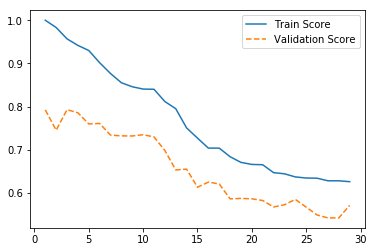

In [68]:
plt.plot(para_leaf,train_score,linestyle="-", label = "Train Score")
plt.plot(para_leaf,validation_score,linestyle="--", label = "Validation Score")
plt.legend()
# 차이가 가장 적으면서, 전체적으로 score가 높은 node 선정

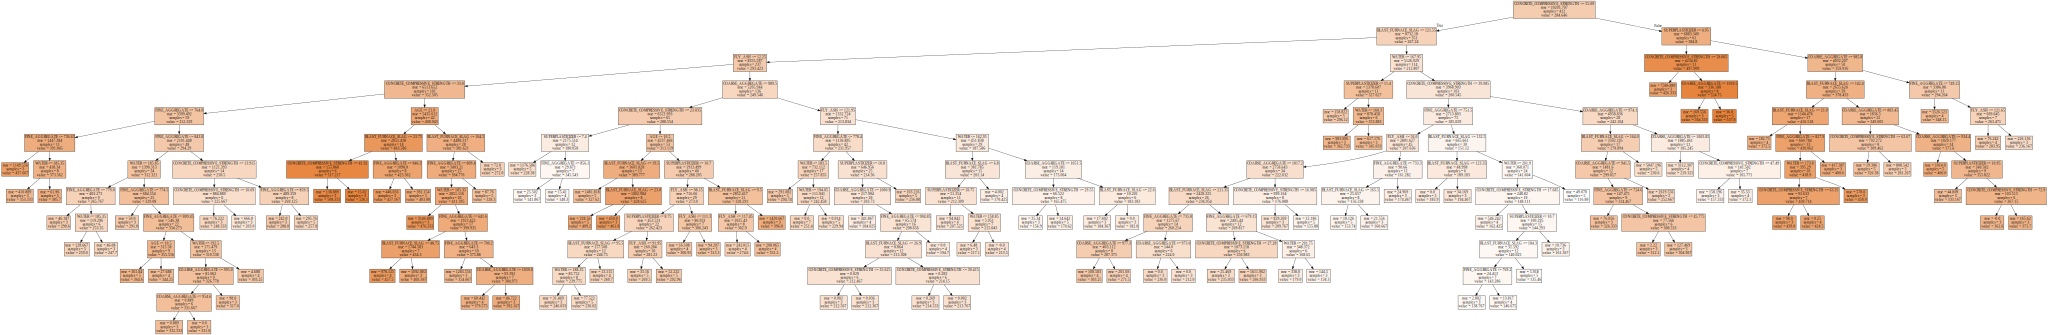

In [69]:
# p.164
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=3)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot",feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# conda에서 graphviz 설치!!

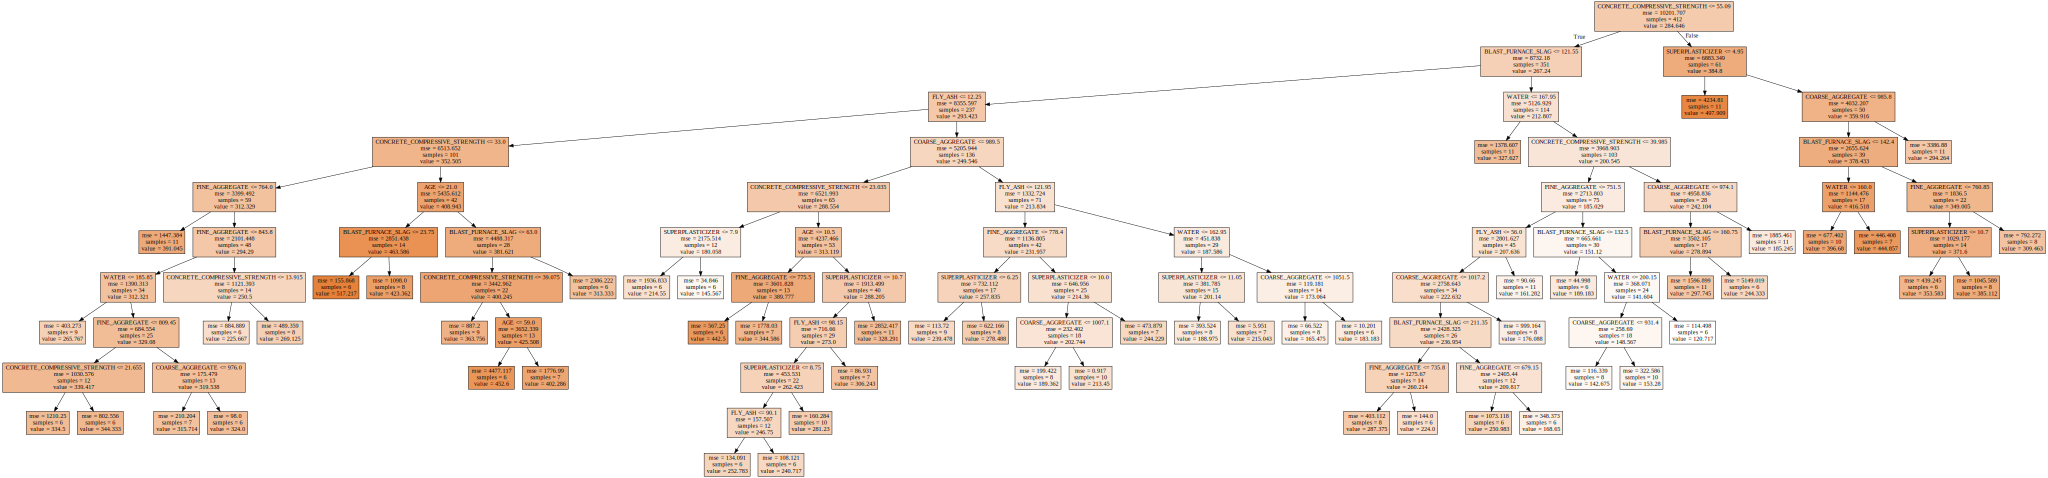

In [70]:
# p.164
v_feature_name = df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=1234, min_samples_leaf=6)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot",feature_names=v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

# conda에서 graphviz 설치!!

In [71]:
train_score = []; validation_score = []
para_split = [n_split * 2 for n_split in range(6,20)]

for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf=6, min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    validation_score.append(tree.score(df_validation_x, df_validation_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["ValidationScore"]=validation_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,ValidationScore
0,12,0.902,0.761
1,14,0.884,0.755
2,16,0.870,0.748
3,18,0.864,0.745
4,20,0.863,0.743
5,22,0.863,0.743
6,24,0.852,0.724
7,26,0.848,0.725
8,28,0.844,0.713
9,30,0.818,0.709


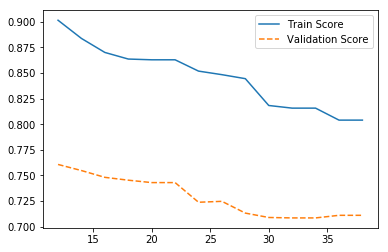

In [72]:
plt.plot(para_split,train_score,linestyle="-", label = "Train Score")
plt.plot(para_split,validation_score,linestyle="--", label = "Validation Score")
plt.legend()

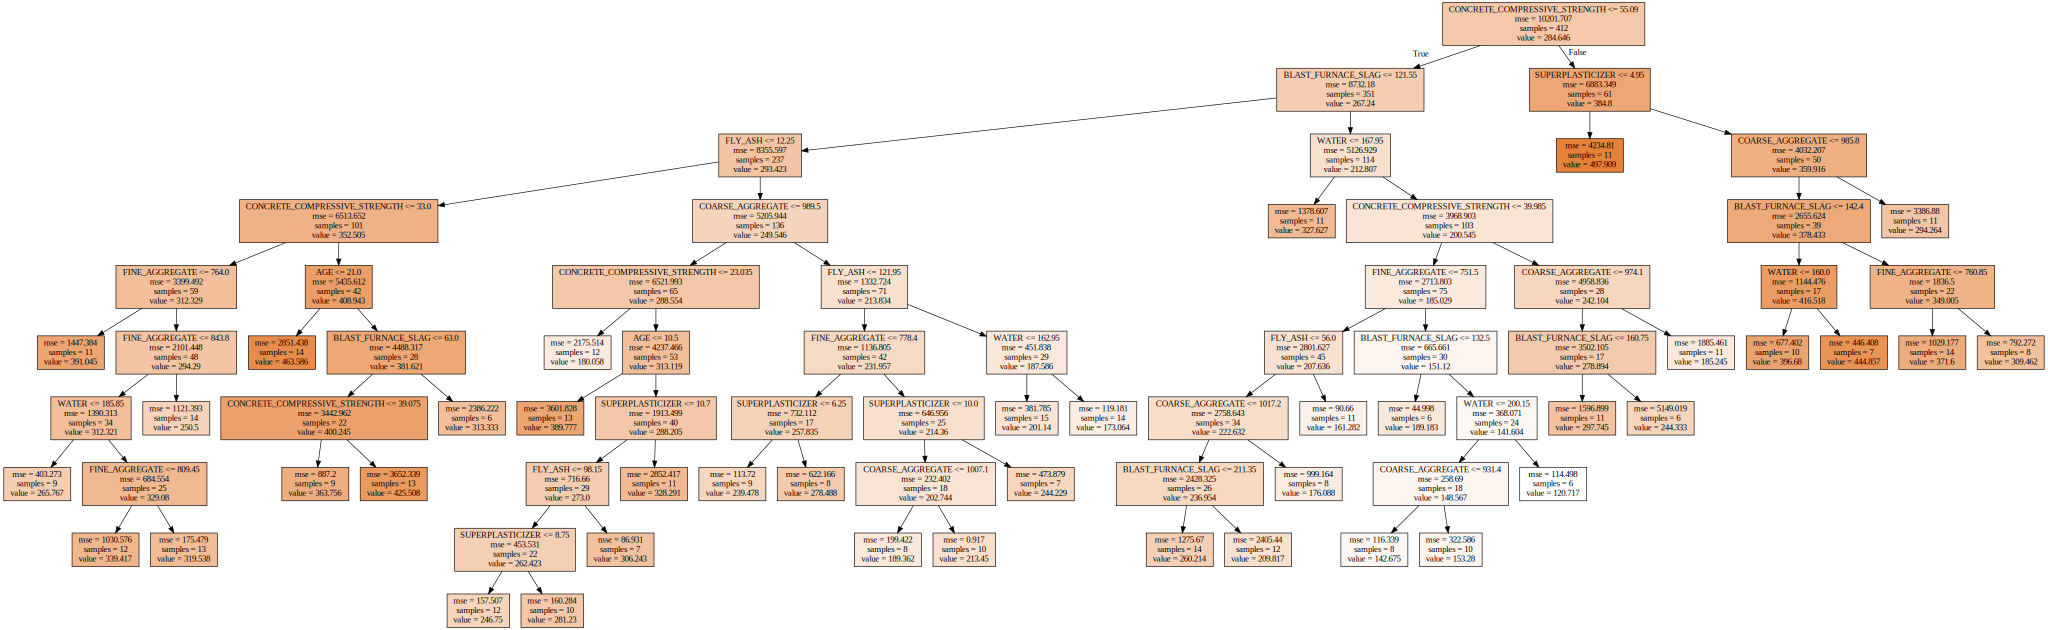

In [73]:
tree_graph = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 6, min_samples_split = 16)
tree_graph.fit(df_train_x, df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot", feature_names=v_feature_name, impurity = True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [74]:
# 
train_score = []; validation_score = []
# max_depth : 최대 깊이 변경
para_depth = [depth for depth in range(4,11)]

for v_max_depth in para_depth :
    tree = DecisionTreeRegressor(random_state = 1234, min_samples_leaf = 6, min_samples_split = 16, max_depth = v_max_depth )
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    validation_score.append(tree.score(df_validation_x, df_validation_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depth["ValidationScore"]=validation_score
df_score_depth.round(3)

,Depth,TrainScore,ValidationScore
0,4,0.655,0.580
1,5,0.774,0.644
2,6,0.834,0.710
3,7,0.861,0.727
4,8,0.869,0.742
5,9,0.870,0.748
6,10,0.870,0.748


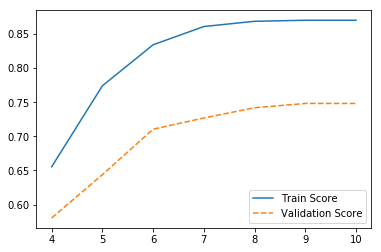

In [75]:
# 최대 깊이 증가에 따라 모델의 설명력은 증가
# Train/test 데이터의 성능 변화를 고려하여 4 선택
plt.plot(para_depth,train_score,linestyle="-", label = "Train Score")
plt.plot(para_depth,validation_score,linestyle="--", label = "Validation Score")
plt.legend()

위에서 leaf node = 8 / split node = 20 / depth = 5가 나왔지만, 최적은 아니다!!!

In [76]:
# p. 174

tree_final = DecisionTreeRegressor(min_samples_leaf=6, min_samples_split=16, max_depth = 6, random_state=1234)
tree_final.fit(df_train_x,df_train_y)

DecisionTreeRegressor(criterion='mse', max_depth=6, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=6,
           min_samples_split=16, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

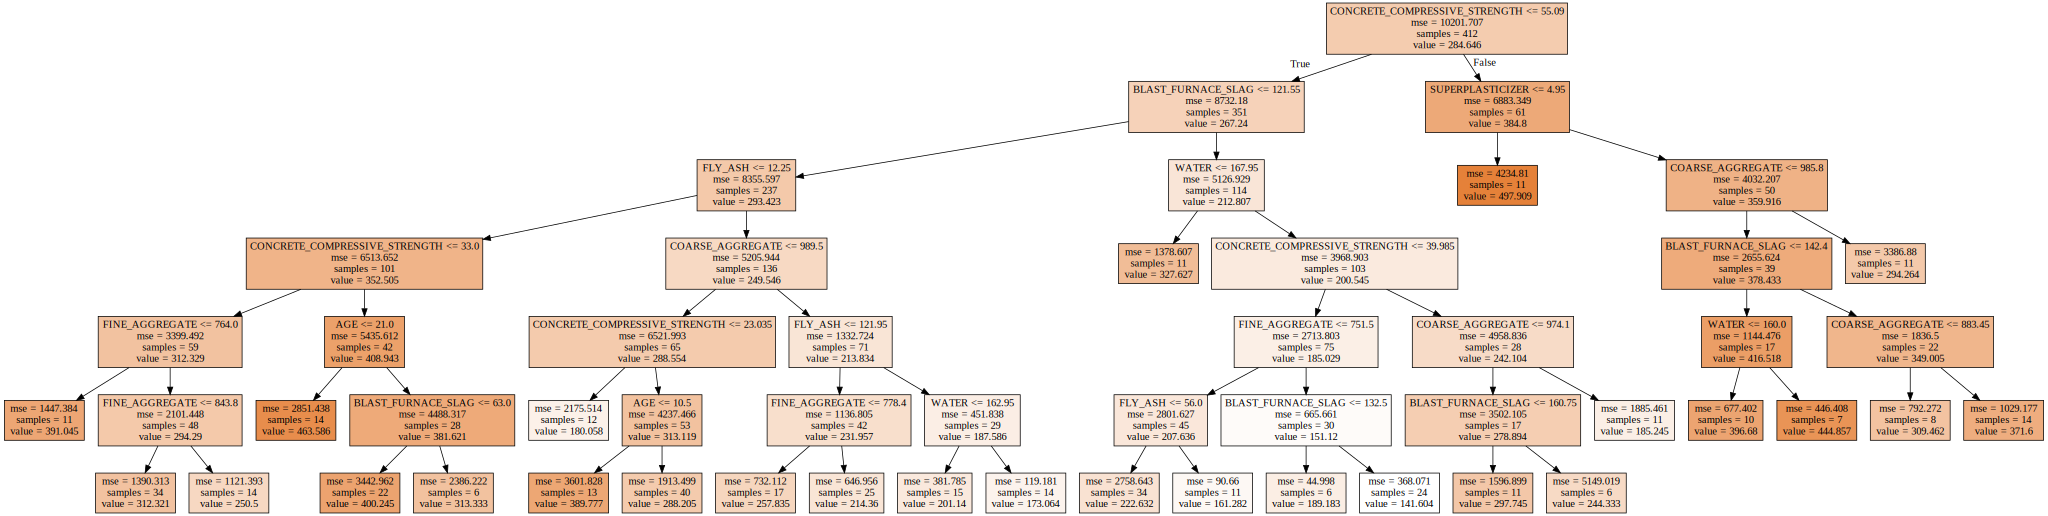

In [77]:
export_graphviz(tree_final, out_file="tree_final.dot", feature_names=v_feature_name, impurity = True, filled=True)
with open("tree_final.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [78]:
train_score_final=[]; validation_score_final=[]

train_score_final.append(tree.score(df_train_x, df_train_y))
validation_score_final.append(tree.score(df_validation_x, df_validation_y))
    
df_score_final = pd.DataFrame()
df_score_final["MinSamplesLeaf"]= [6]
df_score_final["TrainScore"]=train_score_final
df_score_final["ValidationScore"]=validation_score_final

df_score_final.round(3)

,MinSamplesLeaf,TrainScore,ValidationScore
0,6,0.87,0.748


In [79]:
train_score_final=[]; test_score_final=[]

train_score_final.append(tree.score(df_train_x, df_train_y))
test_score_final.append(tree.score(df_test_x, df_test_y))
    
df_score_final = pd.DataFrame()
df_score_final["MinSamplesLeaf"]= [6]
df_score_final["TrainScore"]=train_score_final
df_score_final["TestScore"]=test_score_final

df_score_final.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,6,0.87,0.769


In [80]:
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=tree_final.feature_importances_

df_importance.sort_values("Importance",ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,CONCRETE_COMPRESSIVE_STRENGTH,0.339
1,FLY_ASH,0.194
0,BLAST_FURNACE_SLAG,0.172
4,COARSE_AGGREGATE,0.094
5,FINE_AGGREGATE,0.057
2,WATER,0.050
3,SUPERPLASTICIZER,0.049
6,AGE,0.047


Text(0, 0.5, '변수')

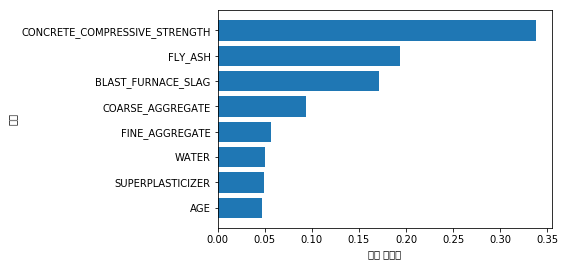

In [81]:
df_importance.sort_values("Importance",ascending = True, inplace = True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [82]:
# p. 178
"""
estimator = DecisionTreeRegressor()

param_grid = {"criterion":["mse", "friedman_mse","mae"],"max_features":["auto","sqrt","log2"], "max_depth":para_depth,"min_samples_split":para_split, "min_samples_leaf":para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring = "r2", n_jobs = -1)
grid_dt.fit(df_train_x, df_train_y)

print("best estimator model: \n{}".format(grid_dt.best_estimator_))
print("\nbest parameter: \n{}".format(grid_dt.best_params_))
print("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))
"""

'\nestimator = DecisionTreeRegressor()\n\nparam_grid = {"criterion":["mse", "friedman_mse","mae"],"max_features":["auto","sqrt","log2"], "max_depth":para_depth,"min_samples_split":para_split, "min_samples_leaf":para_leaf}\n\ngrid_dt = GridSearchCV(estimator, param_grid, scoring = "r2", n_jobs = -1)\ngrid_dt.fit(df_train_x, df_train_y)\n\nprint("best estimator model: \n{}".format(grid_dt.best_estimator_))\nprint("\nbest parameter: \n{}".format(grid_dt.best_params_))\nprint("\nbest score: \n{}".format(grid_dt.best_score_.round(3)))\n'

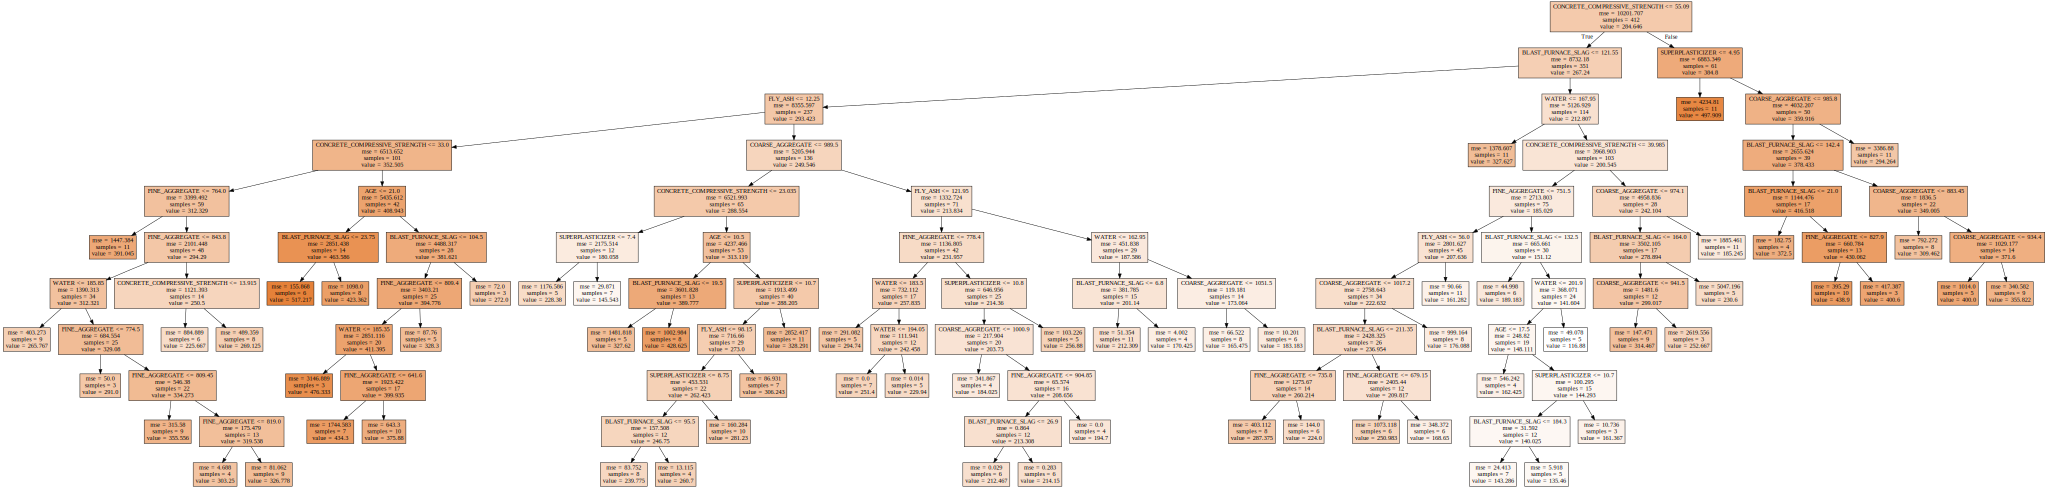

In [83]:
tree_final_graphviz = DecisionTreeRegressor(min_samples_leaf= 3, min_samples_split= 12, max_depth = 10, random_state=1234)
tree_final_graphviz.fit(df_train_x,df_train_y)
export_graphviz(tree_final_graphviz, out_file="tree_final_graphviz.dot", feature_names=v_feature_name, impurity = True, filled=True)
with open("tree_final_graphviz.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

In [84]:
train_score_final_graphviz=[]; validation_score_final_graphviz=[]

train_score_final_graphviz.append(tree_final_graphviz.score(df_train_x, df_train_y))
validation_score_final_graphviz.append(tree_final_graphviz.score(df_validation_x, df_validation_y))
    
df_score_final_graphviz = pd.DataFrame()
df_score_final_graphviz["MinSamplesLeaf"]= [3]
df_score_final_graphviz["TrainScore"]=train_score_final_graphviz
df_score_final_graphviz["ValidationScore"]=validation_score_final_graphviz

df_score_final.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,6,0.87,0.769


In [85]:
train_score_final_graphviz=[]; test_score_final_graphviz=[]

train_score_final_graphviz.append(tree_final_graphviz.score(df_train_x, df_train_y))
test_score_final_graphviz.append(tree_final_graphviz.score(df_test_x, df_test_y))
    
df_score_final_graphviz = pd.DataFrame()
df_score_final_graphviz["MinSamplesLeaf"]= [3]
df_score_final_graphviz["TrainScore"]=train_score_final_graphviz
df_score_final_graphviz["TestScore"]=test_score_final_graphviz

df_score_final.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,6,0.87,0.769
